# 第十四次课后练习

**负责助教：胡天成**

<span style="color:red; font-weight:bold;">请将作业文件命名为 第十四次课后练习+姓名+学号.ipynb, 例如 第十四次课后练习+张三+1000000000.ipynb</span>

<span style="color:red; font-weight:bold;">在作业过程中觉得有心得或者自己拓展学习到有价值内容的，可以在文件名最后加一个#号。例如第十四次课后练习+张三+1000000000+#.ipynb</span>

# 第零部分 代码理解

请认真阅读代码，理解代码的功能，先写出预想的结果。运行并检验结果是否如预期。如果不如预期，请分析理解其中的原因

## **0.1** 高斯拉普拉斯算子

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.autograd import Variable
from math import exp
from PIL import Image
from torchvision.utils import save_image, make_grid

#将最后的矩阵中的元素归一化到0~1之间
def minmaxscaler(data):
    min = torch.min(data)
    max = torch.max(data)    
    return (data - min)/(max-min)
"""
归一化函数：将数据线性映射到[0,1]区间。用于将卷积结果可视化
"""

#LoG变换
def LoG(img,window,window_size,mode="RGB"):
    img1_array = np.array(img,dtype=np.float32)#Image -> array
    img1_tensor = torch.from_numpy(img1_array)# array -> tensor
    """将PIL图像转为NumPy数组，再转为PyTorch张量"""
    # 处理不同通道数的数据
    if mode == 'L':
        img1_tensor = img1_tensor.unsqueeze(0).unsqueeze(0)#h,w -> n,c,h,w 
    else:#RGB or RGBA
        img1_tensor = img1_tensor.permute(2,0,1)# h,w,c -> c,h,w 
        img1_tensor = img1_tensor.unsqueeze(0)#c,h,w -> n,c,h,w 
    """灰度图('L')：添加batch和channel维度
       彩色图：调整通道顺序并添加batch维度"""
    
    channel = img1_tensor.size()[1]
    window = Variable(window.expand(channel, 1, window_size, window_size).contiguous()) # window.expand将卷积核扩展到匹配输入通道数
    output = F.conv2d(img1_tensor, window, padding = window_size//2, groups = channel) 
    """
    使用PyTorch的conv2d函数进行卷积运算
    padding=window_size//2：保持输出尺寸不变
    groups=channel：每个通道单独处理
    """

    output = minmaxscaler(output)# 归一化到0~1之间 # 对结果归一化处理
    if (channel==4):
        save_image(output, "0-1-output.png", normalize=False)
    else:
        save_image(output, "0-1-output.png", normalize=False)
    return output

#近似卷积核
window  = torch.Tensor([[[0,1,1,2,2,2,1,1,0],
                        [1,2,4,5,5,5,4,2,1],
                        [1,4,5,3,0,3,5,4,1],
                        [2,5,3,-12,-24,-12,3,5,2],
                        [2,5,0,-24,-40,-24,0,5,2],
                        [2,5,3,-12,-24,-12,3,5,2],
                        [1,4,5,3,0,3,4,4,1],
                        [1,2,4,5,5,5,4,2,1],
                        [0,1,1,2,2,2,1,1,0]]]) # 定义了一个近似LoG核的权重矩阵(权重分布符合二维高斯函数的二阶导数)
window_size = 9
img = Image.open("./0-1-input.png")
img = img.convert('L') # 将输入图像转换为灰度图(L模式)
LoG(img,window,window_size,img.mode)

"""
代码功能：实现了高斯拉普拉斯算子(LoG)边缘检测算法
使用一个9*9的近似LoG卷积核对输入图像进行卷积运算，并将结果归一化到0-1范围并保存输出图像

预期结果：
输出图像将突出显示原始图像中的边缘区域; 边缘会表现为亮色线条，背景为暗色
由于使用灰度图，输出将是单通道图像。
"""
"""
高斯拉普拉斯算子(LoG)是一种边缘检测算法，结合了高斯平滑和拉普拉斯算子。LoG算子在图像中寻找亮度变化较大的区域，通常用于边缘检测和特征提取

应用：
1.多尺度边缘检测：使用不同尺寸的LoG核
2.结合Canny边缘检测：用LoG结果作为Canny的梯度输入
3.斑点检测：寻找LoG响应的极值点
"""

tensor([[[[0.3599, 0.2810, 0.3368,  ..., 0.2626, 0.2412, 0.3522],
          [0.2884, 0.1694, 0.2250,  ..., 0.1544, 0.1273, 0.2771],
          [0.3318, 0.2127, 0.2660,  ..., 0.2729, 0.2181, 0.3416],
          ...,
          [0.4524, 0.4509, 0.4935,  ..., 0.4699, 0.5073, 0.5406],
          [0.4407, 0.4254, 0.4573,  ..., 0.4762, 0.4752, 0.4977],
          [0.4690, 0.4522, 0.4692,  ..., 0.4923, 0.4750, 0.4883]]]])

![jupyter](./0-1-input.png)


![jupyter](./0-1-output.png)

## **0.2** 高斯模糊

In [ ]:
import cv2

# 1. 读取图像（支持彩色/灰度图）
image = cv2.imread("0-1-input.png")  # 替换为你的图像路径

# 2. 应用高斯模糊
blurred = cv2.GaussianBlur(
    src=image, 
    ksize=(15, 15),   # 高斯核尺寸（必须为奇数）
    sigmaX=0          # X方向标准差（0表示自动计算）
) # 使用OpenCV的高斯模糊函数进行模糊处理！
"""注意：高斯核尺寸（ksize）必须为奇数，且ksize越大，模糊效果越明显。
sigmaX=0表示自动计算标准差（根据ksize自动计算sigma）。sigmaX值越大图像越模糊"""
cv2.imwrite("0-2-output.png", blurred)  # 保存模糊图像

"""
应用：
噪声去除：高斯模糊可有效消除高斯噪声
图像金字塔：构建高斯金字塔用于多尺度分析
预处理：在边缘检测前减少噪声影响
特征提取：在特征检测算法中使用高斯模糊来平滑图像
"""

![jupyter](./0-2-output.png)

## **0.3** 仿射变换

### 图像平移

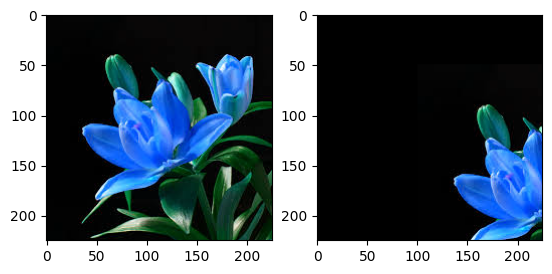

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('0-3-input.png')
H = np.float32([[1,0,100],[0,1,50]]) # 表示[x',y']=I*[x,y]+[100,50],所以是平移变换：水平平移量100，垂直平移量50
rows,cols = img.shape[:2]
res = cv2.warpAffine(img,H,(rows,cols)) #需要图像、变换矩阵、变换后的大小
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(res)

### 图像的扩大与缩小

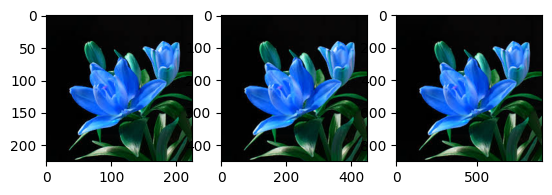

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('0-3-input.png')

res1 = cv2.resize(img,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC) # fx,fy表示缩放因子
#直接规定缩放大小，这个时候就不需要缩放因子
height,width = img.shape[:2] # height=shape[0]表示行数，width=shape[1]表示列数
res2 = cv2.resize(img,(4*width,4*height),interpolation=cv2.INTER_CUBIC) # 指定缩放后的大小（长宽都*4），不需要缩放因子
"""
注（不用掌握）：插值方法：
INTER_NEAREST：最近邻插值（最快）
INTER_LINEAR：双线性插值（默认）
INTER_CUBIC：双三次插值（质量更好）
INTER_LANCZOS4：Lanczos插值（最高质量）
"""
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(res1)
plt.subplot(133)
plt.imshow(res2)


### 图像的旋转

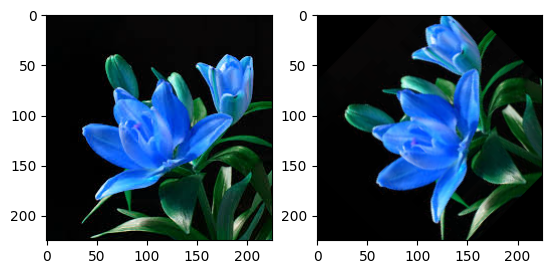

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('0-3-input.png')
rows,cols = img.shape[:2]
#第一个参数旋转中心，第二个参数旋转角度，第三个参数：缩放比例
M = cv2.getRotationMatrix2D((cols/2,rows/2),45,1)
"""
旋转中心点(cols/2, rows/2)
旋转角度45度
缩放因子1.0
"""
#第三个参数：变换后的图像大小
res = cv2.warpAffine(img,M,(rows,cols)) # 图像、变换矩阵、变换后的大小

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(res)

### 图像的仿射

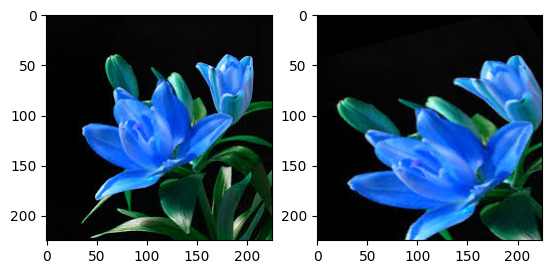

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('0-3-input.png')
rows,cols = img.shape[:2]
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
M = cv2.getAffineTransform(pts1,pts2) # 仿射变换矩阵
"""
第一个参数：原图像中的三个点
第二个参数：变换后图像中的三个点
这两个参数必须是对应的
即M表示变换[[a,c,e],[b,d,f]]
其中[x',y']=A*[x,y]+[e,f]仿射变换，通过pts1和pts2可以列方程求出A和[e,f]。最终这样的仿射变换赋给M
"""
#第三个参数：变换后的图像大小
res = cv2.warpAffine(img,M,(rows,cols))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(res)

### 图像的透射

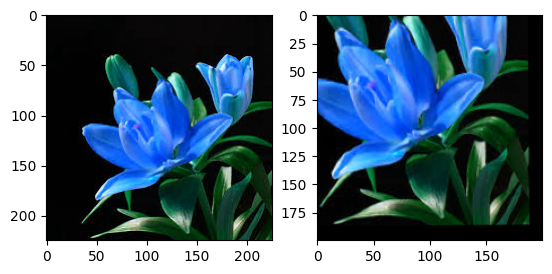

In [ ]:
# 图像透射=射影变换！！
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('0-3-input.png')
rows,cols = img.shape[:2]
pts1 = np.float32([[56,65],[238,52],[28,237],[239,240]])
pts2 = np.float32([[0,0],[200,0],[0,200],[200,200]])
M = cv2.getPerspectiveTransform(pts1,pts2)
"""
第一个参数：原图像中的四个点
第二个参数：变换后图像中的四个点
这两个参数必须是对应的
即M表示变换[[a,b,c],[d,e,f],[g,h,i]]
其中[x',y',1]=M*[x,y,1]透视变换，通过pts1和pts2可以列方程求出M。最终这样的透视变换赋给M（射影变换）

透射特点：
1.需要4组对应点
2.可以模拟视角变化
3.保持直线性但不再保持平行性（射影变换的性质）
"""
res = cv2.warpPerspective(img,M,(200,200))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(res)

## **0.4** DCT变换

In [ ]:
import cv2
import numpy as np

img = cv2.imread("0-3-input.png")
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
y_channel = img_yuv[:,:,0].astype(np.float32)
"""
YUV分离亮度(Y)和色度(UV)
仅对亮度通道处理（人眼对亮度更敏感）
"""

block_size = 8
h, w = y_channel.shape

# 增强填充量以保持分块对齐
pad_h = (block_size - h % block_size) % block_size
pad_w = (block_size - w % block_size) % block_size
padded = cv2.copyMakeBorder(y_channel, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT) # copyMakeBorder函数用于在图像周围添加边框，用0填充 # 0表示黑色填充

"""
填充图像使尺寸能被8整除
JPEG标准使用8*8分块
"""

# 强化版量化表（右下角高频区域量化步长显著增大）
quantization_table = np.array([
    [16,  20,  25,  32,  45,  70,  90, 120],
    [20,  24,  30,  40,  55,  90, 110, 140],
    [25,  30,  40,  50,  65, 100, 130, 160],
    [32,  40,  50,  60,  80, 120, 150, 180],
    [45,  55,  65,  80, 100, 140, 170, 200],
    [70,  90, 100, 120, 140, 180, 210, 240],
    [90, 110, 130, 150, 170, 210, 240, 270],
    [120,140, 160, 180, 200, 240, 270, 300]
], dtype=np.float32)

quality = 0.05  # 降低质量因子
quant_table = quantization_table * (3 - quality*3)  # 增强量化强度系数

"""
量化表分析：
右下角值更大：高频分量量化更粗糙
基于人眼视觉特性设计
quality参数控制整体量化强度
"""

compressed_blocks = []
for i in range(0, padded.shape[0], block_size):
    for j in range(0, padded.shape[1], block_size):
        block = padded[i:i+block_size, j:j+block_size]
        
        # 增强中心化处理
        centered = block - 128 # 中心化处理
        
        # DCT变换
        dct_block = cv2.dct(centered) # dct函数用于计算离散余弦变换
        
        # 增强量化（增加高频截断）
        quantized = np.floor(dct_block / quant_table + 0.5)  # 改用floor取整 # 量化
        quantized[np.abs(quantized) < 0.7] = 0  # 新增小系数截断
        
        # 反量化重建
        dequantized = quantized * quant_table
        idct_block = cv2.idct(dequantized) + 128 # 反DCT变换
        
        compressed_blocks.append(idct_block)
        """
        DCT处理流程：
        中心化：将像素值从[0,255]映射到[-128,127]
        DCT变换：将空域信息转为频域表示
        量化：去除不重要的高频信息
        反变换：重建图像数据

        """

# 图像重建（相同部分省略）
reconstructed = np.zeros_like(padded)
idx = 0
for i in range(0, padded.shape[0], block_size):
    for j in range(0, padded.shape[1], block_size):
        reconstructed[i:i+block_size, j:j+block_size] = compressed_blocks[idx] # 按照块的顺序重建图像
        idx += 1

reconstructed_y = reconstructed[:h, :w].clip(0, 255).astype(np.uint8) # 统一clip，限制范围在0-255之间
compressed_yuv = img_yuv.copy()
compressed_yuv[:,:,0] = reconstructed_y
compressed_bgr = cv2.cvtColor(compressed_yuv, cv2.COLOR_YUV2BGR) # 将YUV转换回BGR

cv2.imwrite("0-3-output-high-compression.png", compressed_bgr)

mse = np.mean((y_channel - reconstructed[:h, :w])**2)
psnr = 10 * np.log10(255**2 / mse)
print(f"PSNR: {psnr:.2f} dB")
"""
PSNR 是衡量图像或视频重建质量的客观指标。在DCT变换代码中，PSNR用于评估压缩后图像与原始图像的质量差异。
PSNR值越高，表示重建图像与原始图像越接近，质量越好。
公式：PSNR = 10 * log10(MAX^2 / MSE)
MAX：图像中像素值的最大值（对于8位图像为255）
MSE：均方误差，表示原始图像与重建图像之间的平均平方差 MSE = 1/mn * ΣΣ (I(i,j) - K(i,j))^2    m,n:图像的行数和列数
"""

PSNR: 27.37 dB


![jupyter](./0-3-input.png) ![jupyter](./0-3-output-high-compression.png)


## 0.5 短视频生成

In [ ]:
import os
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, Video, clear_output

# 新版 MoviePy 2.0+ 导入方式
from moviepy import *


# 配置参数
input_files = ["horse1.jpg", "horse2.jpg", "horse3.jpg", "horse4.jpg"]
media_dir = "pic/"
output_path = os.path.join(media_dir, "output_video.mp4")
audio_path = os.path.join(media_dir, "胡萝卜2m.wav")
target_resolution = (800, 600)

# 创建交互控件
duration_controls = [
    widgets.FloatSlider(
        value=1.0,
        min=0.5,
        max=5.0,
        step=0.1,
        description=f'{file} Duration:',
        style={'description_width': 'initial'}
    ) for file in input_files
]

ui = widgets.VBox([
    widgets.HBox([
        widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1,
                          description='Global Duration:'),
        widgets.Checkbox(value=False, description='Keep Aspect Ratio')
    ]),
    *duration_controls,
    widgets.Button(description="Render Video", button_style='success')
])

display(ui)

def process_media(b):
    clear_output(wait=True)
    display(ui)
    
    try:
        # 参数获取
        global_dur = ui.children[0].children[0].value
        keep_ratio = ui.children[0].children[1].value
        durations = [ctrl.value for ctrl in duration_controls]

        # 1. 文件验证
        if not all(os.path.exists(os.path.join(media_dir, f)) for f in input_files):
            raise FileNotFoundError("Missing image files")
        if not os.path.exists(audio_path):
            raise FileNotFoundError(f"Audio file missing: {audio_path}")

        # 2. 图像处理
        processed = []
        for file in input_files:
            img_path = os.path.join(media_dir, file)
            with Image.open(img_path) as img:
                img = img.convert("RGB")
                
                if keep_ratio:
                    img.thumbnail(target_resolution, Image.Resampling.LANCZOS)
                    canvas = Image.new("RGB", target_resolution, (0, 0, 0))
                    offset = (
                        (target_resolution[0] - img.width) // 2,
                        (target_resolution[1] - img.height) // 2
                    )
                    canvas.paste(img, offset)
                else:
                    canvas = img.resize(target_resolution, Image.Resampling.LANCZOS)
                    
                processed.append(np.array(canvas))

        # 3. 视频合成
        clips = [
            ImageClip(img_array, duration=dur)  # 直接指定时长
            for img_array, dur in zip(processed, durations)
        ]
        
        video = concatenate_videoclips(clips, method="chain")
        
        # 4. 音频处理
        audio = AudioFileClip(audio_path)
        final_duration = min(video.duration, audio.duration)
        video = video.subclipped(0, final_duration)
        audio = audio.subclipped(0, final_duration)
        
        # 5. 输出视频
        video.write_videofile(
            output_path,
            fps=24,
            codec="libx264",
            audio_codec="aac",
            threads=4,
            logger=None  # 禁用日志输出
        )
        
        # 显示结果
        print(f"✅ Video rendered ({final_duration:.1f}s)")
        display(Video(output_path, embed=True))
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()

ui.children[-1].on_click(process_media)

# 第一部分 代码填空

基于HOG特征和SVM实现cifar10分类

1. 下载cifar10数据集并解压

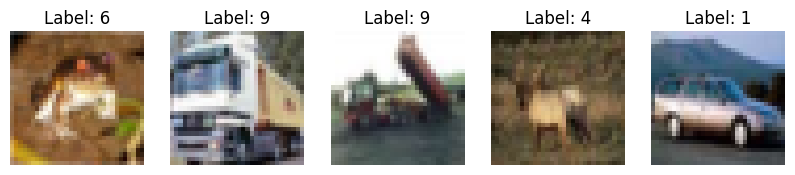

In [22]:
import os
import pickle
import numpy as np
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import random

# 手动下载并解压原始二进制文件
def download_cifar10():
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    save_path = "./cifar-10-python.tar.gz"
    
    # 下载压缩包（约163MB）
    if not os.path.exists(save_path):
        print("下载数据集中...")
        urlretrieve(url, save_path)
    
    # 解压文件
    if not os.path.exists("./cifar-10-batches-py"):
        import tarfile
        with tarfile.open(save_path, 'r:gz') as tar:
            tar.extractall()

# 数据加载函数
def load_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# 执行下载
download_cifar10()

# 加载训练数据并显示前五张图片
# TODO
batch = load_batch(f"./cifar-10-batches-py/data_batch_1") # batch返回一个字典，包含图像数据和标签
# batch[b'data']为原始图像数据，形状为(10000, 3072)
images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # 转换为图像格式
"""batch[b'data']为原始图像数据，形状为(10000, 3072)
3072 = 3*32*32，即每张图像被展平为一维数组(三通道共3072个像素值)
reshape将数据重塑为(10000, 3, 32, 32)的四维数组 (10000张图像，每张3个通道(红绿蓝)，32*32像素)
transpose(0, 2, 3, 1)调整维度顺序为(10000, 32, 32, 3)将通道维度移到最后，使得为图像格式能输出"""

labels = batch[b'labels']
# 显示前五张图片
plt.figure(figsize = (10,2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

2. 提取HOG特征,注意提取特征之前需要吧rgb图像先转换成灰度图像，输出给的是mac air运行的一个参考特征提取时间

In [29]:
from skimage.feature import hog
import numpy as np
import joblib
import os
import time
import pickle as pk


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def getData(filePath):
    TrainData = []
    for childDir in os.listdir(filePath):
        if 'data_batch' in childDir:
            f = os.path.join(filePath, childDir)
            data = unpickle(f)
            train = np.reshape(data[b'data'], (10000, 3, 32 * 32))
            labels = np.reshape(data[b'labels'], (10000, 1))
            fileNames = np.reshape(data[b'filenames'], (10000, 1))
            datalebels = zip(train, labels, fileNames)
            TrainData.extend(datalebels)
        if childDir == "test_batch":
            f = os.path.join(filePath, childDir)
            data = unpickle(f)
            test = np.reshape(data[b'data'], (10000, 3, 32 * 32))
            labels = np.reshape(data[b'labels'], (10000, 1))
            fileNames = np.reshape(data[b'filenames'], (10000, 1))
            TestData = zip(test, labels, fileNames)
    return TrainData, TestData


def getFeat(TrainData, TestData):
    # TODO 定义hot特征提取的必要参数
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)

    os.makedirs('./train/', exist_ok=True)
    os.makedirs('./test/', exist_ok=True)

    for data in TestData:
        # TODO 提取hog特征
        gray_imag = rgb2gray(data[0].transpose(1, 0).reshape(32, 32, 3)) # transpose(1, 0)将数据转置为(32, 32, 3)的形状
        fd = hog(gray_imag, 
                 orientations = orientations,
                 pixels_per_cell = pixels_per_cell,
                 cells_per_block = cells_per_block)
        fd = np.append(fd, data[1][0]) # 将标签添加到特征向量末尾

        filename = list(data[2])
        fd_name = str(filename[0], encoding = "utf-8") .split('.')[0]+'.feat'
        fd_path = os.path.join('./test/', fd_name)
        joblib.dump(fd, fd_path)
    print("Test features are extracted and saved.")
    
    for data in TrainData:
        # TODO
        gray_imag = rgb2gray(data[0].transpose(1, 0).reshape(32, 32, 3))
        fd = hog(gray_imag, 
                 orientations = orientations,
                 pixels_per_cell = pixels_per_cell,
                 cells_per_block = cells_per_block)
        fd = np.append(fd, data[1][0]) # 将标签添加到特征向量末尾
        
        filename = list(data[2])
        fd_name = str(filename[0], encoding = "utf-8") .split('.')[0]+'.feat'
        fd_path = os.path.join('./train/', fd_name)
        joblib.dump(fd, fd_path)
    print("Train features are extracted and saved.")

def rgb2gray(im):
    gray = im[:, :, 0]*0.2989+im[:, :, 1]*0.5870+im[:, :, 2]*0.1140
    return gray

if __name__ == '__main__':
    t0 = time.time()
    filePath = r'./cifar-10-batches-py'
    TrainData, TestData = getData(filePath)
    getFeat(TrainData, TestData)
    t1 = time.time()
    print("Features are extracted and saved.")
    print('The cast of time is:%f'%(t1-t0))

Test features are extracted and saved.
Train features are extracted and saved.
Features are extracted and saved.
The cast of time is:11.975646


3. 训练SVM进行图像分类，正确率50%左右，处理时间大概一分钟，思考怎么优化，或者尝试之前上课讲过的别的分类方法

In [ ]:
from sklearn.svm import LinearSVC
import joblib
import numpy as np
import glob
import os
import time

train_feat_path = './train/'
test_feat_path = './test/'
if __name__ == "__main__":
    t0 = time.time()
    fds = []
    labels = []
    num = 0
    total = 0
    for feat_path in glob.glob(os.path.join(train_feat_path, '*.feat')):
        data = joblib.load(feat_path)
        fds.append(data[:-1])
        labels.append(data[-1])
        # print(data.shape)
    print("Done loading train features.")
    #TODO 训练一个SVM分类器，并用测试集进行测试
    svc = LinearSVC(C=1e9) 
    svc.fit(fds, labels)  

    # 方式1: 高斯核函数 慢
    """from sklearn.svm import SVC
    svc = SVC(kernel = 'rbf')
    svc.fit(fds, labels)"""

    # 方式2: kNN    accuracy略低但是快很多
    """
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(fds, labels)
    """
    # The classification accuracy is 0.467400
    # The cast of time is :47.784474

    # 方式3: Random Forest
    """from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    rf.fit(fds, labels)"""
    # The classification accuracy is 0.501100
    # The cast of time is :80.859193

    # 其他: kmeans和GaussianNB此处不适合，因为HOG特征可能不适合直接kmeans聚类；HOG特征间存在空间相关性，违反朴素贝叶斯独立性假设、也不服从正态分布
    for feat_path in glob.glob(os.path.join(test_feat_path, '*.feat')):
        data = joblib.load(feat_path)
        if data[-1] == svc.predict(data[:-1].reshape(1, -1))[0]: num += 1
        total += 1
    rate = num / total
    t1 = time.time()
    print('The classification accuracy is %f'%rate)
    print('The cast of time is :%f'%(t1-t0))


Done loading train features.
The classification accuracy is 0.501100
The cast of time is :80.859193
